## Homework 5

### Light: 

- добавить в блокнот решения Homework 3 построение модели RandomForest;

- воспользоваться одним из способов работы с разбалансированным датасетом Churn.


### Pro: 

- добавить в блокнот решения Homework 3 построение модели RandomForest;

- использовать все способы работы с разбалансированным датасетом Churn.

https://www.kaggle.com/becksddf/churn-in-telecoms-dataset

In [1]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, PowerTransformer
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import auc, plot_roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
def value_of_metrics_cv(X, y, model, title):
    sns.set_style('whitegrid')
    st_fold = StratifiedKFold(n_splits=7, shuffle=True, random_state=5)
    params = {'estimator': model, 'X': X, 'y': y, 'cv': st_fold}
    scores = cross_validate(**params, scoring=('accuracy', 'balanced_accuracy',
                                               'recall', 'precision', 'f1', 'roc_auc'))
    print('Accuracy: ', scores['test_accuracy'].mean())
    print('Balanced accuracy: ', scores['test_balanced_accuracy'].mean())
    print('Recall: ', scores['test_recall'].mean())
    print('Precision: ', scores['test_precision'].mean())
    print('F1: ', scores['test_f1'].mean())
    print('Roc_AUC: ', scores['test_roc_auc'].mean())
    conf_matrix_list_of_arrays = []
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()
    plt.close(fig)
    for i, (train, test) in enumerate(st_fold.split(X, y)):
        model.fit(X[train], y[train])
        viz = plot_roc_curve(model, X[test], y[test],
                                     name='ROC fold {}'.format(i), ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        conf_matrix = confusion_matrix(y[test], model.predict(X[test]))
        conf_matrix_list_of_arrays.append(conf_matrix)
    mean_сonf_matrix = np.round(np.mean(conf_matrix_list_of_arrays, axis=0), 0)
    print('Confusion Matrix:')
    print(pd.DataFrame(mean_сonf_matrix.astype(int)))
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    roc_auc = auc(mean_fpr, mean_tpr)
    plt.title(title, y=1.01, fontsize=14)
    plt.plot(mean_fpr, mean_tpr, 'b', label = 'Mean  AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right', fontsize=11)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [3]:
# функция, объединяющая GridSearch нужных нам классификаторов и показ их метрик

class BestClassifier():

    def __init__(self, X_train, X_test, transformer=None):
        self.X_train = X_train
        self.y_train = y_train
        self.transformer = transformer
        
    def _make_pipeline(self, clf):
        if self.transformer is None:
            self.pipe = make_pipeline(clf)
        else:
            self.pipe = make_pipeline(self.transformer, clf)
        
    def _fit_gs_and_print_gs_results(self, gs):
        gs.fit(self.X_train, self.y_train)
        self.params = gs.best_params_
        # remove the name of estimator from parameters names
        if '__' in list(self.params.keys())[0]:
            keys_list = [key.split('__')[1] for key in list(self.params.keys())]
            self.params = dict(zip(keys_list, self.params.values()))
        print('Best score (roc_auc): {}'.format(gs.best_score_))
        print('Best parameters: {}\n'.format(self.params))
        print('С лучшими параметрами и кросс-валидацией:')
 
    def random_forest(self):
        estimator = 'randomforestclassifier__'
        self.grid = {estimator +'n_estimators': [30, 40, 50, 60, 70],
                     estimator +'criterion': ['gini', 'entropy'],
                     estimator +'max_depth': [None, 5, 6, 7, 8, 9, 10, 11],
                     estimator +'class_weight': [None, 'balanced']}
        self._make_pipeline(RandomForestClassifier())
        gs = GridSearchCV(self.pipe, self.grid, cv=5, scoring='roc_auc')
        self._fit_gs_and_print_gs_results(gs)
        self._make_pipeline(RandomForestClassifier(**self.params))
        value_of_metrics_cv(self.X_train, self.y_train,
                            self.pipe, 'Random Forest')

    def svm(self):
        estimator = 'svc__'
        self.grid = {estimator +'kernel': ['poly', 'rbf', 'sigmoid'],
                     estimator +'C': [0.5, 0.7, 1, 2, 3],
                     estimator +'degree': [1, 2, 3, 4, 5, 6],
                     estimator +'gamma': ['scale', 'auto'],
                     estimator +'class_weight': [None, 'balanced']}
        self._make_pipeline(svm.SVC())
        gs = GridSearchCV(self.pipe, self.grid, cv=5, scoring='roc_auc')
        self._fit_gs_and_print_gs_results(gs)
        self._make_pipeline(svm.SVC(**self.params))
        value_of_metrics_cv(self.X_train, self.y_train,
                            self.pipe, 'Support Vector Machine')

    def knn(self):
        estimator = 'kneighborsclassifier__'
        self.grid = {estimator +'n_neighbors': list(np.arange(5,37,2)),
                     estimator +'weights': ['uniform', 'distance'],
                     estimator +'leaf_size': list(np.arange(10,70,10)),
                     estimator +'p': [1, 2, 3, 4],
                     estimator +'metric': ['minkowski', 'chebyshev']}
        self._make_pipeline(KNeighborsClassifier())
        gs = GridSearchCV(self.pipe, self.grid, cv=5, scoring='roc_auc')
        self._fit_gs_and_print_gs_results(gs)
        self._make_pipeline(KNeighborsClassifier(**self.params))
        value_of_metrics_cv(self.X_train, self.y_train,
                            self.pipe, 'k Nearest Neighbors')

### Загрузим данные и сделаем их предобработку из Homework 3

In [4]:
df = pd.read_csv('telecom_churn.csv')

# Кодирование категориальных признаков
df['Churn'] = df['Churn'].astype('int64')
df['International plan'] = df['International plan'].map({'No':0, 'Yes':1})
df['Voice mail plan'] = df['Voice mail plan'].map({'No':0, 'Yes':1})

# Area code - несущественный признак, удалим его
df.drop(['Area code'], axis=1, inplace=True)

# Разбиваем State на 4 группы исходя из степени оттока клиентов
df_2 = df[['State','Churn']].groupby(['State']).mean()
df_2.loc[(df_2['Churn'] <= 0.095557), 'Group'] = 0
df_2.loc[(df_2['Churn'] > 0.095557) & (df_2['Churn'] <= 0.136364), 'Group'] = 1
df_2.loc[(df_2['Churn'] > 0.136364) & (df_2['Churn'] <= 0.183219), 'Group'] = 2
df_2.loc[(df_2['Churn'] > 0.183219), 'Group'] = 3
df_2['Group'] = df_2['Group'].astype(int)
states = list(df_2.index)
values = list(df_2.Group)
groups = dict(zip(states, values))
df['State'] = df['State'].map(groups)

# Приводим признаки к нормальному распределению
bad_features = ['Number vmail messages', 'Total intl minutes',
                'Total intl calls', 'Total intl charge']
yeo_johnson_transform = PowerTransformer(method='yeo-johnson', standardize=False)
for feature in bad_features:
    df[feature + ' yeo johnson'] = \
    yeo_johnson_transform.fit_transform(df[feature].values.reshape(df.shape[0],-1))
df = df.drop(bad_features, axis=1)
df.head()

,State,Account length,International plan,Voice mail plan,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Customer service calls,Churn,Number vmail messages yeo johnson,Total intl minutes yeo johnson,Total intl calls yeo johnson,Total intl charge yeo johnson
0,3,128,0,1,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,1,0,1.042542,15.324847,1.521895,3.569697
1,1,107,0,1,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,1,0,1.044457,22.392807,1.521895,5.203943
2,3,137,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,0,0,-0.000000,19.465415,2.022525,4.517823
3,1,84,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,2,0,-0.000000,9.343981,2.394410,2.194421
4,2,75,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,3,0,-0.000000,15.508817,1.521895,3.616731


### Работа с разбалансированностью датасета

In [5]:
print('Форма датасета:', df.shape)
print('Баланс классов:', dict(df.Churn.value_counts()))
print('Доля каждого класса:', (dict(df.Churn.value_counts(normalize=True))))

Форма датасета: (3333, 19)
Баланс классов: {0: 2850, 1: 483}
Доля каждого класса: {0: 0.8550855085508551, 1: 0.14491449144914492}


In [6]:
y_train = df.Churn
X_train = df.drop('Churn', axis=1)
scaler = StandardScaler()
X_std = scaler.fit_transform(X_train)

In [7]:
undersampler = RandomUnderSampler(random_state=27)
oversampler = RandomOverSampler(random_state=27)
smote = SMOTE(random_state=27)

In [8]:
best_clf = BestClassifier(X_std, y_train)
best_clf_undersampled = BestClassifier(X_std, y_train, undersampler)
best_clf_oversampled = BestClassifier(X_std, y_train, oversampler)
best_clf_smote = BestClassifier(X_std, y_train, smote)

#### Undersampling, oversampling and SMOTE with Random Forest

Best score (roc_auc): 0.9243545208597095
Best parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 11, 'n_estimators': 40}

С лучшими параметрами и кросс-валидацией:
Accuracy:  0.9543968530808551
Balanced accuracy:  0.8581255010283143
Recall:  0.7225672877846792
Precision:  0.9509705257615406
F1:  0.8198458969085544
Roc_AUC:  0.9161654139275622
Confusion Matrix:
     0   1
0  405   3
1   20  49


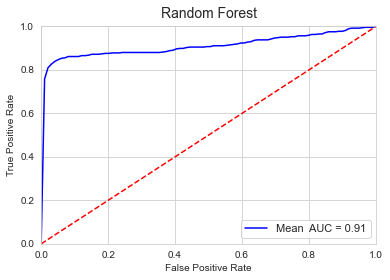

In [9]:
best_clf.random_forest()

Best score (roc_auc): 0.9154164405860012
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 30}

С лучшими параметрами и кросс-валидацией:
Accuracy:  0.8854025887084395
Balanced accuracy:  0.8676508179385417
Recall:  0.8426501035196688
Precision:  0.5778416688838338
F1:  0.6833892764573696
Roc_AUC:  0.9068999310367597
Confusion Matrix:
     0   1
0  363  44
1   10  59


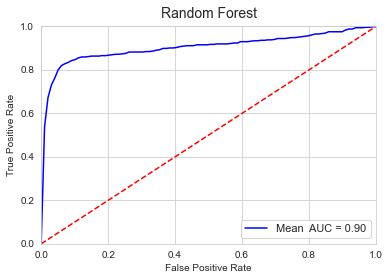

In [10]:
best_clf_undersampled.random_forest()

Best score (roc_auc): 0.9225842150479291
Best parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 40}

С лучшими параметрами и кросс-валидацией:
Accuracy:  0.9522966419272112
Balanced accuracy:  0.889568908430801
Recall:  0.8012422360248449
Precision:  0.860702959598415
F1:  0.8292157380114552
Roc_AUC:  0.9131022650843622
Confusion Matrix:
     0   1
0  397  10
1   14  55


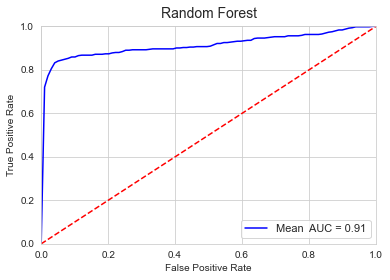

In [11]:
best_clf_oversampled.random_forest()

Best score (roc_auc): 0.9227930382227045
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 60}

С лучшими параметрами и кросс-валидацией:
Accuracy:  0.942393309525068
Balanced accuracy:  0.8812000336936399
Recall:  0.7950310559006212
Precision:  0.8062456117967465
F1:  0.7997442486414842
Roc_AUC:  0.9167070755945437
Confusion Matrix:
     0   1
0  394  14
1   14  55


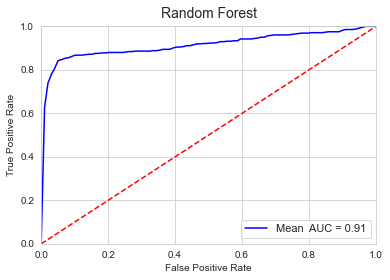

In [12]:
best_clf_smote.random_forest()

#### Undersampling, oversampling and SMOTE with SVM

Best score (roc_auc): 0.9153125565201663
Best parameters: {'C': 3, 'class_weight': None, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}

С лучшими параметрами и кросс-валидацией:
Accuracy:  0.9378959130822142
Balanced accuracy:  0.819245460709655
Recall:  0.6521739130434783
Precision:  0.890045653408187
F1:  0.7514727750390847
Roc_AUC:  0.9114222087367868
Confusion Matrix:
     0   1
0  402   6
1   24  45


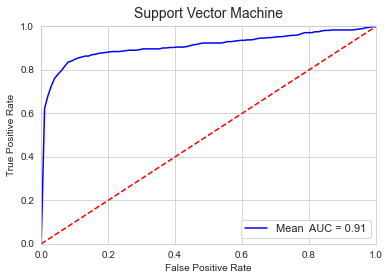

In [13]:
best_clf.svm()

Best score (roc_auc): 0.9049115647796467
Best parameters: {'C': 2, 'class_weight': None, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}

С лучшими параметрами и кросс-валидацией:
Accuracy:  0.8637876534261503
Balanced accuracy:  0.8558706304869987
Recall:  0.84472049689441
Precision:  0.5201440029191918
F1:  0.6430668661646346
Roc_AUC:  0.9007102645210062
Confusion Matrix:
     0   1
0  353  54
1   11  58


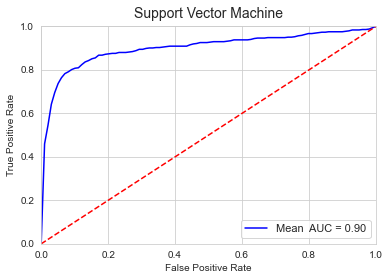

In [14]:
best_clf_undersampled.svm()

Best score (roc_auc): 0.9089424700066318
Best parameters: {'C': 0.5, 'class_weight': None, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}

С лучшими параметрами и кросс-валидацией:
Accuracy:  0.9036954404403271
Balanced accuracy:  0.8611512145719307
Recall:  0.8012422360248447
Precision:  0.6359267036245425
F1:  0.7076125037551572
Roc_AUC:  0.9057941839271763
Confusion Matrix:
     0   1
0  375  32
1   14  55


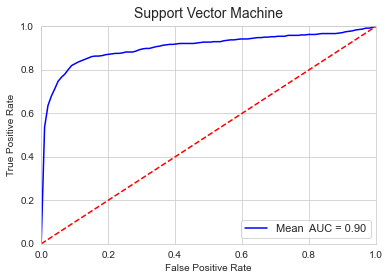

In [15]:
best_clf_oversampled.svm()

Best score (roc_auc): 0.904551682040152
Best parameters: {'C': 0.5, 'class_weight': None, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}

С лучшими параметрами и кросс-валидацией:
Accuracy:  0.9117942774594116
Balanced accuracy:  0.8486914875981373
Recall:  0.7598343685300206
Precision:  0.6746984462173149
F1:  0.7138639327711438
Roc_AUC:  0.9014935069922282
Confusion Matrix:
     0   1
0  382  25
1   17  52


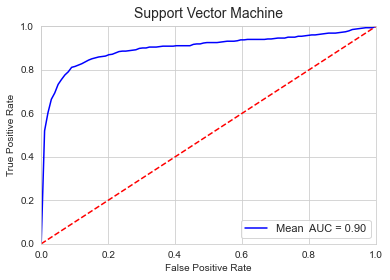

In [16]:
best_clf_smote.svm()

#### Undersampling, oversampling and SMOTE with kNN

Best score (roc_auc): 0.8979169115873878
Best parameters: {'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 35, 'p': 2, 'weights': 'distance'}

С лучшими параметрами и кросс-валидацией:
Accuracy:  0.8769866437140893
Balanced accuracy:  0.5764290546899241
Recall:  0.15320910973084884
Precision:  0.989010989010989
F1:  0.2637851302551355
Roc_AUC:  0.8966293742508578
Confusion Matrix:
     0   1
0  407   0
1   58  11


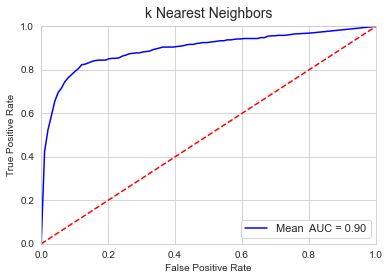

In [17]:
best_clf.knn()

Best score (roc_auc): 0.8961817236389944
Best parameters: {'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}

С лучшими параметрами и кросс-валидацией:
Accuracy:  0.8868868302037797
Balanced accuracy:  0.8401471500896054
Recall:  0.7743271221532091
Precision:  0.5840386475184868
F1:  0.6649293091632941
Roc_AUC:  0.8934735255067736
Confusion Matrix:
     0   1
0  369  38
1   16  53


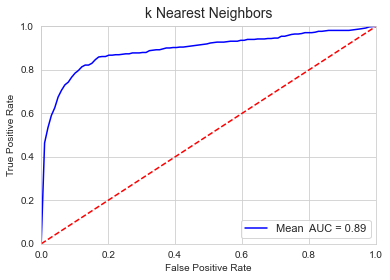

In [18]:
best_clf_undersampled.knn()

Best score (roc_auc): 0.8886319670525111
Best parameters: {'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 35, 'p': 2, 'weights': 'distance'}

С лучшими параметрами и кросс-валидацией:
Accuracy:  0.8640814816492635
Balanced accuracy:  0.8371289360739489
Recall:  0.7991718426501035
Precision:  0.5210924942861449
F1:  0.6299926973517321
Roc_AUC:  0.8911819241103129
Confusion Matrix:
     0   1
0  356  51
1   14  55


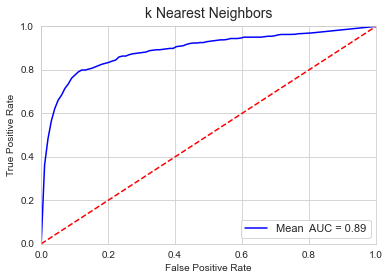

In [19]:
best_clf_oversampled.knn()

Best score (roc_auc): 0.8937490768372822
Best parameters: {'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 33, 'p': 1, 'weights': 'uniform'}

С лучшими параметрами и кросс-валидацией:
Accuracy:  0.8601887295798823
Balanced accuracy:  0.8451693838522484
Recall:  0.824016563146998
Precision:  0.5112703751110645
F1:  0.6302314102863285
Roc_AUC:  0.895025248286118
Confusion Matrix:
     0   1
0  353  54
1   12  57


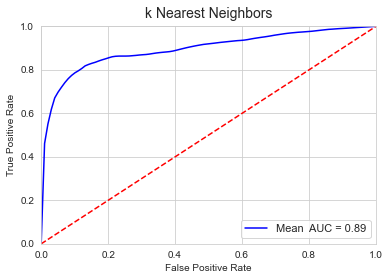

In [20]:
best_clf_smote.knn()

#### Стекинг лучших моделей без ресемплинга данных

In [9]:
random_forest = RandomForestClassifier(class_weight=None, criterion='entropy', max_depth=11, n_estimators=40)
svmclf = svm.SVC(C=3, class_weight=None, degree=1, gamma='auto', kernel='rbf', probability=True)
knn = KNeighborsClassifier(leaf_size=10, metric='minkowski', n_neighbors=35, p=2, weights='distance')

In [10]:
ensemble = VotingClassifier(estimators=[('random_forest', random_forest), ('svmclf', svmclf)],
                            voting='soft', weights=[1,1])

ensemble_2 = VotingClassifier(estimators=[('random_forest', random_forest), ('knn', knn)],
                              voting='soft', weights=[2,1])

ensemble_3 = VotingClassifier(estimators=[('random_forest', random_forest), ('svmclf', svmclf), ('knn', knn)],
                              voting='soft', weights=[2,3,1])

In [11]:
ensemble.fit(X_std, y_train)

VotingClassifier(estimators=[('random_forest',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=11,
                                                     n_estimators=40)),
                             ('svmclf',
                              SVC(C=3, degree=1, gamma='auto',
                                  probability=True))],
                 voting='soft', weights=[1, 1])

In [12]:
import pickle

In [13]:
pickle.dump(ensemble, open('ensemble.pkl','wb'))

Accuracy:  0.9492979581769816
Balanced accuracy:  0.8405275874905032
Recall:  0.6873706004140786
Precision:  0.9489251675652021
F1:  0.7957376969087843
Roc_AUC:  0.9173419608202215
Confusion Matrix:
     0   1
0  404   3
1   21  48


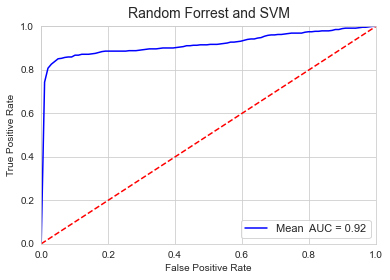

In [23]:
value_of_metrics_cv(X_std, y_train, ensemble, 'Random Forrest and SVM')

Accuracy:  0.9396947458228576
Balanced accuracy:  0.7962243785453503
Recall:  0.5942028985507246
Precision:  0.9833473269347807
F1:  0.7401418515950535
Roc_AUC:  0.9131838060866192
Confusion Matrix:
     0   1
0  406   1
1   29  40


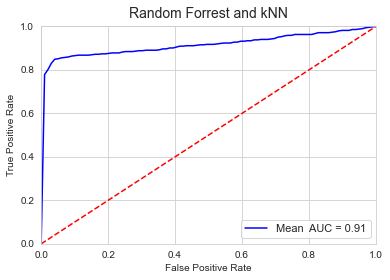

In [24]:
value_of_metrics_cv(X_std, y_train, ensemble_2, 'Random Forrest and kNN')

Accuracy:  0.9450950191397315
Balanced accuracy:  0.822595617672344
Recall:  0.650103519668737
Precision:  0.9577083479873076
F1:  0.77313058540203
Roc_AUC:  0.9153569112009011
Confusion Matrix:
     0   1
0  405   2
1   24  45


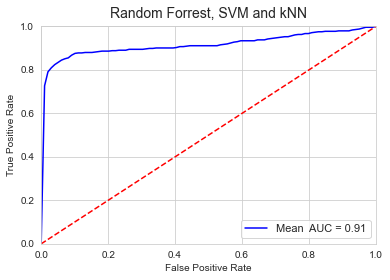

In [25]:
value_of_metrics_cv(X_std, y_train, ensemble_3, 'Random Forrest, SVM and kNN')

**Вывод:** для данной задачи лучшие результаты дал стекинг разных моделей без ресемплинга данных. Однако, если речь идет о том, что нам важно найти максимальное количество всех, кто перестанет пользоваться услугами компании (Churn==1), то лучше всего произвести undersampling данных и построить Random Forest, такая модель дает самый высокий recall (почти 85%).